<a href="https://colab.research.google.com/github/richtea88/CM3710/blob/main/Siamese_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Richard Thomson - 0603831 - CM3710 - Machine Learning & AI
## Siamese Triplet (script 1 of 2)
For loading the provided data into the scripts please edit the locations:

DATA_DIR to the location of the 'Train_Test_Coursework' folder.

and 

EVAL_DIR to the location of the 'Evaluation Data Set' folder.

MODELS_DIR is an additional folder you can set if you'd like to save any models.

The first few code blocks are setting constants and functions. The script that runs through the functions starts in code block 12. The script ends by spitting out the evaluation of the model.

In [1]:
# Import Libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import resnet
from tensorflow.keras.models import Sequential
# BOO Colab - Multimode was added in python 3.8 - google is on 3.6, sooo 2016
# from statistics import multimode, mean
from statistics import mode, mean, harmonic_mean
from statistics import StatisticsError

# and there goes keras triplet loss
# import tensorflow_addons as tfa

In [2]:
# set data folder locations - this will be the two data folders provided
# the models folder is an additional folder for saving/loading models

MODELS_DIR = '/content/drive/MyDrive/Colab Notebooks/Models/'
EVAL_DIR = '/content/drive/MyDrive/Evaluation Data Set/'
DATA_DIR = '/content/drive/MyDrive/Train_Test_Coursework/'
model_no = 1
img_height = 800
img_width = 800
channels = 3
target_shape = (img_height,img_width)

In [3]:
def preprocess_image(filename):
    # read the file from file path
    img_str = tf.io.read_file(filename)
    # decode as png file
    img = tf.image.decode_png(img_str, channels=channels)
    # convert to float32 tensor
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize - currently set to Bilenar, also tested lanczos, nearest neighbour, cubic
    img = tf.image.resize(img, target_shape, method=tf.image.ResizeMethod.BILINEAR)
    return img

In [4]:
def preprocess_triplets(anchor, positive, negative):
    # takes in 3 png files, preprocesses and returns a tuple of 3 tensors
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [5]:
def visualize(anchor, positive, negative):
    # A function for displaying 3 triplets - Anchor, Positive and Negative

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])
    plt.show()
    print()

I tested out a number of different architectures for the embedding models. Due to model size and training time these were reduced to work within google colab.
The below functions are used to create the siamese triplet network

In [6]:
def create_model():
    # create convolutional network as input for siamese network
    inp = tf.keras.layers.Input(shape=target_shape + (3,), name="input1")
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=7, padding='same', activation='relu', input_shape=target_shape + (3,))(inp)
    x = tf.keras.layers.MaxPooling2D(pool_size=3)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3)(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation=None)(x)  # No activation on final dense layer
    model = tf.keras.Model(inp, x, name='Embedding')
    model.summary()
    return model

In [7]:
def get_siamese_network():

    # Define the tensors for the triplet of input images
    anchor_input = tf.keras.layers.Input(shape=target_shape + (3,), name="anchor_input")
    positive_input = tf.keras.layers.Input(shape=target_shape + (3,), name="positive_input")
    negative_input = tf.keras.layers.Input(shape=target_shape + (3,), name="negative_input")

    # Get embedding model
    embedding_model = create_model()

    # create distance layer from class
    distances = DistanceLayer()(
        embedding_model(anchor_input), embedding_model(positive_input), embedding_model(negative_input),
    )

    # Connect the inputs with the outputs
    siamese_network = tf.keras.Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

    # return the model
    return embedding_model, siamese_network

In [8]:
class DistanceLayer(layers.Layer):
    """
    The distance layer accepts three embedded inputs,
    the anchor, the positive and the negative.
    it computes the distance from the anchor to the positive and negative tensors
    and returns both values.
    Distance Function - https://keras.io/examples/vision/siamese_network/
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [9]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
       siamese class courtesy of
       https://keras.io/examples/vision/siamese_network/
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]



The below function is used to predict an image file and return a classification rather than a distance

In [10]:
def prediction_process(png_image_filepath):
    '''This function takes a png image filepath
    it converts the png to a tensor and preprocesses
    for input into the siamese model

    in order to return a classification the image is loaded
    as the anchor image. A positive and negative image is chosen from
    a list of each classes images.
    The model returns distances from the anchor image to each class

    a function to select which class the image most likely belongs to
    this could either be taking a mean of all the distances returned for each class
    then selecting the class with the closest mean distance

    or a function that selects based on the class with the most number of wins
    each win being the class with the lowest distance'''

    # Check file is png
    if not png_image_filepath.endswith('png'):
        raise ValueError('Please select a PNG image file')
        return

    # create class sets
    isometrics = [file for file in all if file['Class'] == 'Isometric']
    pids = [file for file in all if file['Class'] == 'P&ID']
    photos = [file for file in all if file['Class'] == 'Photo']
    dds = [file for file in all if file['Class'] == 'Detail Drawing']

    # set anchor image
    anchor = png_image_filepath

    # create 3 siamese triples for each class with that class being the positive image
    # this selects randomly from the class sets
    predictors = []
    for i in range(0, 5, 1):
        if i == 0:
            predictors.append((anchor, random.choice(isometrics), random.choice(pids)))
            predictors.append((anchor, random.choice(isometrics), random.choice(photos)))
            predictors.append((anchor, random.choice(isometrics), random.choice(dds)))
        if i == 1:
            predictors.append((anchor, random.choice(pids), random.choice(isometrics)))
            predictors.append((anchor, random.choice(pids), random.choice(photos)))
            predictors.append((anchor, random.choice(pids), random.choice(dds)))
        if i == 2:
            predictors.append((anchor, random.choice(photos), random.choice(isometrics)))
            predictors.append((anchor, random.choice(photos), random.choice(pids)))
            predictors.append((anchor, random.choice(photos), random.choice(dds)))
        if i == 3:
            predictors.append((anchor, random.choice(dds), random.choice(isometrics)))
            predictors.append((anchor, random.choice(dds), random.choice(pids)))
            predictors.append((anchor, random.choice(dds), random.choice(photos)))

    winners = []
    iso_distances = []
    pid_distances = []
    photo_distances = []
    dd_distances = []
    # for each of the triplets
    for j, dic in enumerate(predictors):
        # pre-process images
        triplet = preprocess_triplets(dic[0], dic[1]['File'], dic[2]['File'])
        # expand dims to shape array like it has a batch number
        triplet = (tf.expand_dims(triplet[0], axis=0), tf.expand_dims(triplet[1], axis=0), tf.expand_dims(triplet[2], axis=0))
        # get the classes of the positive and negative triplet
        pos_class, neg_class = dic[1]['Class'], dic[2]['Class']
        # predict their distances from the anchor image
        pos_dist, neg_dist = siamese_model.predict(triplet)
        # select the winner as the class that is closest
        if pos_dist[0] < neg_dist[0]:
            winners.append(pos_class)
        elif pos_dist[0] > neg_dist[0]:
            winners.append(neg_class)
        else:
            winners.append('Undetermined')

        # log all the distances in a class distance list
        if pos_class == 'Isometric':
            iso_distances.append(pos_dist[0])
        elif pos_class == 'P&ID':
            pid_distances.append(pos_dist[0])
        elif pos_class == 'Photo':
            photo_distances.append(pos_dist[0])
        elif pos_class == 'Detail Drawing':
            dd_distances.append(pos_dist[0])

        if neg_class == 'Isometric':
            iso_distances.append(neg_dist[0])
        elif neg_class == 'P&ID':
            pid_distances.append(neg_dist[0])
        elif neg_class == 'Photo':
            photo_distances.append(neg_dist[0])
        elif neg_class == 'Detail Drawing':
            dd_distances.append(neg_dist[0])
    # Winner is the class with the most wins
    try:
      winner = mode(winners)
    # however if we get more than a single mode, mode will throw a Statistics Error (Python 3.7 and lower)
    except StatisticsError as e:
      print (e)
      print('Multimode only available in python 3.8+')
      print('using alternative method of classification')
      # calculate the mean of each classes distances
      iso_mean = mean(iso_distances)
      pid_mean = mean(pid_distances)
      photo_mean = mean(photo_distances)
      dd_mean = mean(dd_distances)
      # store each clases mean in list
      means = [iso_mean, pid_mean, photo_mean, dd_mean]
      classes = ['Isometric', 'P&ID', 'Photo', 'Detail Drawing']
      # find the smallest mean
      mean_min = min(means)
      # get it's index in the means list
      min_index = means.index(mean_min)
      # select the same index from the classes list - voila, a winner!
      winner = classes[min_index]
      print(f'{png_image_filepath} predicted as {winner}')
      return winner
    print(f'{png_image_filepath} predicted as {winner}')
    return winner

The below function is used to predict against the evaluation match to produce some model metrics.

In [11]:

def evaluate_model():
    '''Evaluate model uses the provided evaluation files
    10 images from each class are predicted against.
    it then provides some metrics on the prediction performance.'''
    test_files = []
    # split files into classes
    for file in os.listdir(EVAL_DIR):
        file = EVAL_DIR + file
        if 'Isometric' in file:
            test_files.append({'File': file, 'Class':'Isometric'})
        if 'pid' in file:
            test_files.append({'File': file, 'Class':'P&ID'})
        if 'photo' in file:
            test_files.append({'File': file, 'Class':'Photo'})
        if 'Detail' in file:
            test_files.append({'File': file, 'Class':'Detail Drawing'})
    # create a blank confusion matrix
    confusion_matrix = {'Isometric':{'Isometric': 0, 'P&ID':0, 'Photo':0, 'Detail Drawing':0},
                        'P&ID': {'Isometric': 0, 'P&ID': 0, 'Photo': 0, 'Detail Drawing':0},
                        'Photo': {'Isometric': 0, 'P&ID': 0, 'Photo': 0, 'Detail Drawing':0},
                        'Detail Drawing': {'Isometric': 0, 'P&ID': 0, 'Photo': 0, 'Detail Drawing':0}}
    # for each files in test files
    for dic in test_files:
        # predict the class
        prediction = prediction_process(dic['File'])
        classification = dic['Class']
        # Updates the appropriate field
        confusion_matrix[classification][prediction] +=1

    # turn confusion matrix into a dataframe
    confusion_matrix_df = pandas.DataFrame(confusion_matrix)
    classes = ['Isometric', 'P&ID', 'Photo', 'Detail Drawing']
    class_stats = []
    # for each class
    for c in classes:
        # create list of other classes
        other_classes = [cls for cls in classes if cls != c]
        # true positives are of class class
        TP = confusion_matrix_df[c][c]
        TN = 0
        # true negatives are other classes predictions that aren't of the current class
        for o_c in other_classes:
            for oo_c in other_classes:
                TN += confusion_matrix_df[o_c][oo_c]
        # get the row of the current class        
        FP_row = confusion_matrix_df.loc[c]
        FP = 0
        for i, item in FP_row.iteritems():
            # if not the column of the current class, count for false positives
            if i != c:
                FP += item
        # get the column of the curren class
        FN_col = confusion_matrix_df[c]
        FN = 0
        for j, row in FN_col.iteritems():
            # if not the row of the first class, count for false negatives
            if j != c:
                FN += row
        # calculate stats per class and append
        precision = TP/(FP+TP)
        recall = TP/(TP+FN)
        F1 = harmonic_mean([precision, recall])
        class_stats.append(
            {'Class': c, 'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN, 'Precision': precision, 'Recall': recall, 'F1': F1})
    print()
    # create class stats data frame
    class_stats_df = pandas.DataFrame(class_stats)
    # for total model stats sum each of the true positive, negative and false positive, negatives
    Total_TP = class_stats_df['TP'].sum()
    Total_FP = class_stats_df['FP'].sum()
    Total_TN = class_stats_df['TN'].sum()
    Total_FN = class_stats_df['FN'].sum()
    # create overall stats for model
    Total_precision = Total_TP / (Total_TP + Total_FN)
    Total_Recall = Total_TP / (Total_TP + Total_FN)  # Killer movie, man
    Micro_F1 = harmonic_mean([Total_precision, Total_Recall])
    Macro_F1 = class_stats_df['F1'].sum() / 4
    model_stats = [{'TP': Total_TP, 'TN': Total_TN, 'FP': Total_FP, 'FN': Total_FN, 'Precision': Total_precision,
                   'Recall': Total_Recall, 'Micro F1': Micro_F1, 'Macro F1': Macro_F1}]
    # convert to dataframe
    model_stats_df = pandas.DataFrame(model_stats)
    return confusion_matrix_df, class_stats_df, model_stats_df

The code below loads in the necessary data for training and testing.

In [12]:
# load data from google drive
# I've provided a link via e-mail to a google drive below where the image data can be retrieved from
# these images can be stored in your google drive and loaded with the below sricpt
# replace the paths below with your folder locations
isometric_image_path = DATA_DIR + 'Isometric/'
p_and_id_image_path = DATA_DIR + 'Piping and Instrumentation Diagram/'
photo_image_path = DATA_DIR + 'Photo/'
detail_drawing_image_path = DATA_DIR + 'Detail Drawing/'

isometric_files = []
for iso in os.listdir(isometric_image_path):
  f_path = isometric_image_path + iso
  isometric_files.append({'Class':'Isometric','File':f_path})

p_and_id_files = []
for pid in os.listdir(p_and_id_image_path):
  f_path = p_and_id_image_path + pid
  p_and_id_files.append({'Class':'P&ID','File':f_path})

photo_files = []
for photo in os.listdir(photo_image_path):
  f_path = photo_image_path + photo
  photo_files.append({'Class':'Photo','File':f_path})

detail_drawing_files = []
for dd in os.listdir(detail_drawing_image_path):
  f_path = detail_drawing_image_path + dd
  detail_drawing_files.append({'Class':'Detail Drawing','File':f_path})

# combine file lists
all = []
all.extend(isometric_files)
all.extend(p_and_id_files)
all.extend(photo_files)
all.extend(detail_drawing_files)

# summary of files
print(f'{len(isometric_files)} isometric images')
print(f'{len(p_and_id_files)} p&id images')
print(f'{len(photo_files)} photo images')
print(f'{len(detail_drawing_files)} detail drawing images')
number_of_images = len(all)
print(f'{number_of_images} total images')

50 isometric images
50 p&id images
50 photo images
50 detail drawing images
200 total images


In [13]:
# creating triplets from image_data sets.
anchors = []
positives = []
negatives = []
for dic in all:
    # for each file - set file as anchor
  anchors.append(dic['File'])
    # select a random file from the same class that isn't the current file
  pos_list = [d for d in all if d['Class'] == dic['Class'] and d != dic]
  pos_choice = random.choice(pos_list)
  positives.append(pos_choice['File'])
    # select a random file from the other classes
  neg_list = [d for d in all if d['Class'] != dic['Class']]
  neg_choice = random.choice(neg_list)
  negatives.append(neg_choice['File'])


In [14]:
# load each list into a dataset object
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchors)
positive_dataset = tf.data.Dataset.from_tensor_slices(positives)
negative_dataset = tf.data.Dataset.from_tensor_slices(negatives)

# zip lists together
dataset =  tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
# shuffle dataset
dataset = dataset.shuffle(buffer_size=1024)
# loads image files from filepaths and converts to array.
dataset = dataset.map(preprocess_triplets)

# take first 80% for training dataset
train_dataset = dataset.take(round(number_of_images * 0.8))
# skip first 80% - take 20% for validation
val_dataset = dataset.skip(round(number_of_images * 0.8))

# split dataset into batches of 16
train_dataset = train_dataset.batch(8, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(8, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)


A visual check of the triplets created.

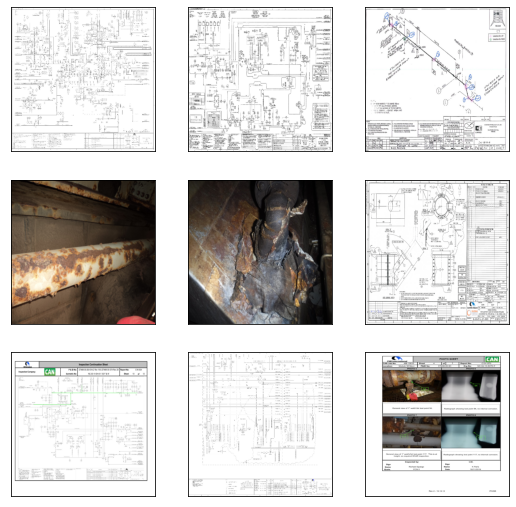

In [15]:
# visualise the first 3 sets of triplets
visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])


Create the Siamese Triplet Model and Train

In [16]:
# create embedding model and siamese network
embedding_model, siamese_network = get_siamese_network()
# add to class provided by keras - this class has all the functions for calculating the loss and updating the weights of the identical input models
siamese_model = SiameseModel(siamese_network)
# compile - colab doesn't support the tripletsemihardloss 
siamese_model.compile(optimizer=optimizers.Adam(0.0001))#, loss=tfa.losses.TripletSemiHardLoss())

Model: "Embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input1 (InputLayer)         [(None, 800, 800, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 800, 800, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 266, 266, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 266, 266, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 266, 266, 32)      51232     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 88, 88, 32)       0         
 2D)                                                     

In [ ]:
# Kyle, my sincerest apologies if you're training this in Colab. The model takes approx 6 seconds an epoch run locally on my machine. Feel free to reduce epochs to save time
history = siamese_model.fit(
    train_dataset,
    epochs=6, validation_data=val_dataset)

Epoch 1/2
20/20 [==============================] - 736s 36s/step - loss: 0.3162 - val_loss: 0.0983
Epoch 2/2
14/20 [====================>.........] - ETA: 3:18 - loss: 0.0753

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(6)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Training Loss (Above)

Cosine Similarity of positive and negative images compared to anchor image.

In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding_model(anchor),
    embedding_model(positive),
    embedding_model(negative))

cosine_similarity = metrics.CosineSimilarity()
positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Evaluate the model using the custom evaluation process

In [ ]:
# evaluate the model
confusion_matrix, class_stats, model_stats = evaluate_model()

no unique mode; found 2 equally common values
Multimode only available in python 3.8+
using alternative method of classification
/content/drive/MyDrive/Evaluation Data Set/Detail Drawing (4).png predicted as Detail Drawing
/content/drive/MyDrive/Evaluation Data Set/Detail Drawing (7).png predicted as P&ID
/content/drive/MyDrive/Evaluation Data Set/Detail Drawing (1).png predicted as Detail Drawing
/content/drive/MyDrive/Evaluation Data Set/Detail Drawing (8).png predicted as P&ID
no unique mode; found 2 equally common values
Multimode only available in python 3.8+
using alternative method of classification
/content/drive/MyDrive/Evaluation Data Set/Detail Drawing (9).png predicted as P&ID
/content/drive/MyDrive/Evaluation Data Set/Isometric (1).png predicted as P&ID
/content/drive/MyDrive/Evaluation Data Set/Isometric (4).png predicted as Detail Drawing
/content/drive/MyDrive/Evaluation Data Set/Isometric (7).png predicted as Detail Drawing
no unique mode; found 3 equally common values

Display the results in dataframes

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

# Display Confusion Matrix
data_table.DataTable(confusion_matrix)

,Isometric,P&ID,Photo,Detail Drawing
Isometric,4,0,0,1
P&ID,1,8,2,6
Photo,0,0,8,0
Detail Drawing,5,2,0,3


In [ ]:
# Display Class Stats
data_table.DataTable(class_stats)

,Class,TP,TN,FP,FN,Precision,Recall,F1
0,Isometric,4,29,1,6,0.800000,0.4,0.533333
1,P&ID,8,21,9,2,0.470588,0.8,0.592593
2,Photo,8,30,0,2,1.000000,0.8,0.888889
3,Detail Drawing,3,23,7,7,0.300000,0.3,0.300000


In [ ]:
# Display Model Stats
data_table.DataTable(model_stats)

,TP,TN,FP,FN,Precision,Recall,Micro F1,Macro F1
0,23,103,17,17,0.575,0.575,0.575,0.578704
